In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{b}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{b}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay $\tau$ for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{b}
\end{equation}

Each visibility ratio is proportional to a complex exponential
\begin{equation}
\frac{V_{i j}}{V_{k l}} \propto \exp{\bigg(-2\pi i \cdot(\tau_i - \tau_j - \tau_k + \tau_l)\bigg)}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

***


In [1]:
import random
import numpy as np

import estdel

# using estdel_nn.data_creation as a convient way for me to import and prepare waterfall data
from estdel_nn.data_creation import data_manipulation as dm

Load (or generate) a list of redundant baselines and get their data

In [2]:
red_bls, gains, uvd = dm.load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv',
                                            '../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [3]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = '../data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = '../data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

In [4]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [5]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

***

Get the unique antennas

In [6]:
unique_ants = []
for key in _bl_dict.keys():
    if len(_bl_dict[key]) >= 2:
        for sep in _bl_dict[key]:
            for ant in sep:
                if ant not in unique_ants:
                    unique_ants.append(ant)

In [7]:
unique_ants = sorted(unique_ants)

Assign each antenna a random delay in the range of -100ns to 100ns

In [8]:
generated_ant_delays = {ant : np.random.uniform(low = -0.0100, high = 0.0100) for ant in unique_ants}

Generate a list of abstracted waterfalls of visibility ratios from redundant baselines ( pairs of redundant separations)

In [9]:
num_waterfalls = 100
list_o_sep_pairs = []

for i in range(num_waterfalls):
    
    # Randomly select a redundant baseline
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    
    while len(_bl_dict[unique_baseline]) < 2:
        unique_baseline = random.sample(_bl_dict.keys(), 1)[0]

    # randomly select two sepearations from that baseline
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    
    list_o_sep_pairs.append(two_seps)

***
Construct Data

In [10]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [11]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

In [12]:
waterfalls = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_waterfalls):
    

    two_seps = list_o_sep_pairs[i]       
    true_delay = get_target(two_seps, generated_ant_delays)
    waterfall = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    waterfalls.append(waterfall)
 

In [13]:
freqs = np.linspace(0.100,0.200,1024)

In [14]:
channel_width_in_GHz = np.mean(np.diff(freqs))

In [15]:
def scale_delays_to_ns(delays, channel_width_in_GHz = np.mean(np.diff(np.linspace(0.100,0.200,1024)))):
    return delays / channel_width_in_GHz

In [16]:
# delays in nanoseconds
true_ant_delays = {ant :scale_delays_to_ns(generated_ant_delays[ant]) for ant in generated_ant_delays.keys()}

In [17]:
np.unique(list_o_sep_pairs)

array([  1,  11,  12,  13,  14,  23,  24,  25,  26,  27,  36,  37,  38,
        39,  40,  41,  51,  52,  53,  54,  55,  65,  66,  67,  68,  69,
        70,  71,  82,  83,  84,  86,  87,  88, 120, 121, 122, 123, 124,
       137, 138, 139, 140, 141, 142, 143], dtype=int32)

In [18]:
solver = estdel.DelaySolver(list_o_sep_pairs, waterfalls, conversion_fn='default')

In [19]:
true_b = solver.true_b(true_ant_delays)

In [20]:
solver.predict()

In [21]:
pred_b = solver.watefall_time_predictions

In [22]:
# http://maxwell.ucsc.edu/~drip/133/ch4.pdf
red_chi2 = np.sum((pred_b - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [23]:
red_chi2

1.0

In [24]:
red_chi2a = np.sum((pred_b -  - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [25]:
red_chi2

1.0

In [26]:
import matplotlib.pyplot as plt

[]

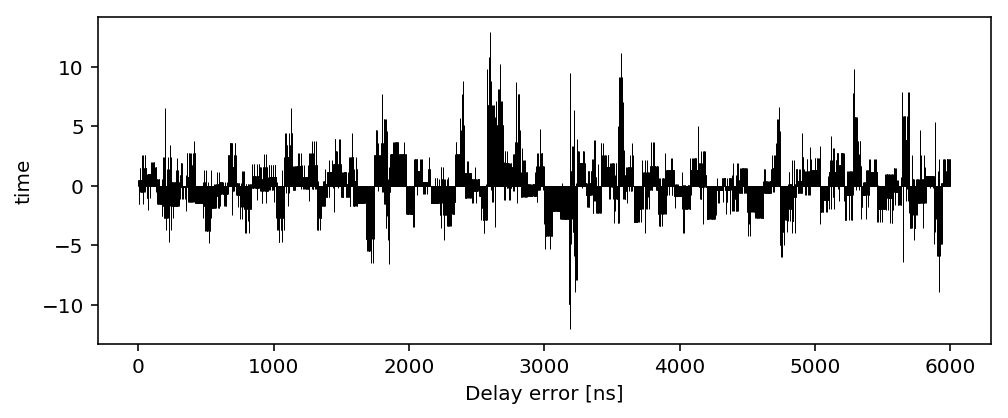

In [27]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.vlines(range(len(pred_b)), 0, true_b- pred_b, lw = 0.5)
plt.xlabel("Delay error [ns]")
plt.ylabel("time")
plt.plot()

[]

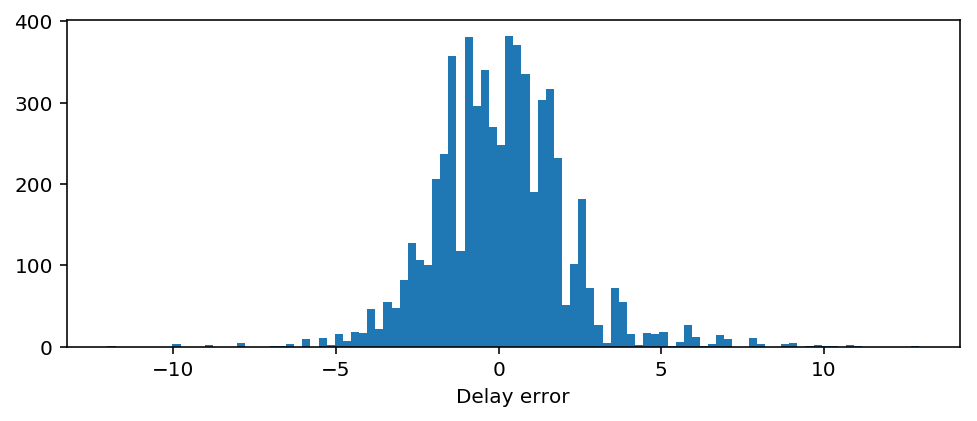

In [28]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.hist(true_b- pred_b, bins = 100)
plt.xlabel("Delay error")
plt.plot()

In [29]:
np.std(np.abs(true_b- pred_b))

1.3531395691153068

In [30]:
A = solver.A

In [31]:
x_prediction_eval = np.linalg.lstsq(A[:, solver.unique_ants], pred_b, rcond = None)

In [32]:
x_prediction = x_prediction_eval[0]

In [33]:
x_prediction

array([  48.53675488,   31.15607083,   79.39574516,    4.54429175,
          1.04661787,   98.82139462,  -78.58105893,  -83.93944117,
         56.92965357,  -85.76031472,  -53.3006416 ,   20.58596648,
        -51.64222669,   67.75086597,   -2.29735168,   42.33770961,
        -44.87094019,  -19.22947067,   89.97526226,  -47.14938634,
         77.7639261 ,  -88.17706475,   -1.47760508,  -63.88056989,
        -67.84635133,   75.91083243,  -69.15602734,  -14.56913263,
        -16.48523784,   -5.15971116,   34.8116432 ,  -29.54932281,
       -110.60880546,  -23.30228148,   86.18043545,   88.05534068,
        -13.40443146,   49.26900636,   16.24734923,  -56.35020637,
         17.31335785,   50.59408084,   88.77551921,   45.81051697,
        -48.70232591,  -96.37243583])

In [34]:
predicted_antenna_delays = {solver.unique_ants[i]: x_prediction[i] for i in range(len(x_prediction))}
predicted_antenna_delays

{1: 48.53675488423813,
 11: 31.156070834443142,
 12: 79.39574516344837,
 13: 4.5442917493290516,
 14: 1.0466178693656722,
 23: 98.82139462120526,
 24: -78.58105893348723,
 25: -83.93944117343912,
 26: 56.92965356813886,
 27: -85.76031472151632,
 36: -53.300641599347834,
 37: 20.58596647870072,
 38: -51.642226686333785,
 39: 67.75086596762092,
 40: -2.2973516813903956,
 41: 42.33770961215569,
 51: -44.87094019088312,
 52: -19.229470672606546,
 53: 89.97526225992289,
 54: -47.14938633996487,
 55: 77.76392609751143,
 65: -88.17706475413857,
 66: -1.4776050788992805,
 67: -63.880569891854535,
 68: -67.8463513300327,
 69: 75.91083243468354,
 70: -69.15602733682438,
 71: -14.569132625891868,
 82: -16.485237839688246,
 83: -5.159711163947463,
 84: 34.81164320266437,
 86: -29.549322807124522,
 87: -110.60880546404553,
 88: -23.302281483883206,
 120: 86.18043544988433,
 121: 88.05534068276852,
 122: -13.404431458742977,
 123: 49.26900636046674,
 124: 16.247349230065968,
 137: -56.35020636925985

In [35]:
error = {}
error_ls = []
for key in sorted(predicted_antenna_delays.keys()):
    print('{:3d}: {:6.2f}, {:6.2f}'.format(key,predicted_antenna_delays[key], scale_delays_to_ns(generated_ant_delays[key])))
    error[key] = scale_delays_to_ns(generated_ant_delays[key]) - predicted_antenna_delays[key]
    error_ls.append(error[key])

  1:  48.54,  46.13
 11:  31.16,  22.37
 12:  79.40,  72.77
 13:   4.54,   8.28
 14:   1.05,  10.34
 23:  98.82,  87.65
 24: -78.58, -82.60
 25: -83.94, -82.21
 26:  56.93,  65.17
 27: -85.76, -73.25
 36: -53.30, -64.36
 37:  20.59,  16.75
 38: -51.64, -51.76
 39:  67.75,  72.47
 40:  -2.30,  10.22
 41:  42.34,  64.29
 51: -44.87, -52.36
 52: -19.23, -23.43
 53:  89.98,  94.42
 54: -47.15, -33.85
 55:  77.76,  94.12
 65: -88.18, -102.28
 66:  -1.48,  -9.01
 67: -63.88, -65.72
 68: -67.85, -60.34
 69:  75.91,  85.67
 70: -69.16, -55.13
 71: -14.57,   7.43
 82: -16.49, -27.08
 83:  -5.16,  -5.71
 84:  34.81,  37.89
 86: -29.55, -15.15
 87: -110.61, -89.89
 88: -23.30,   2.38
120:  86.18,  91.34
121:  88.06, 101.21
122: -13.40,   3.19
123:  49.27,  72.98
124:  16.25,  40.33
137: -56.35, -63.00
138:  17.31,  18.17
139:  50.59,  53.57
140:  88.78, 100.68
141:  45.81,  61.85
142: -48.70, -28.68
143: -96.37, -67.55


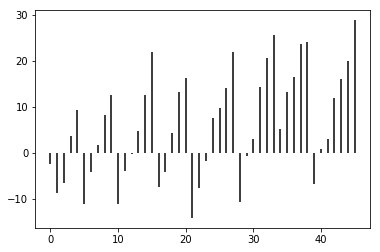

In [36]:
plt.vlines(range(len(error_ls)), 0, error_ls)